https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [192]:
import numpy as np 
import tensorflow as tf 
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
import matplotlib.pyplot as plt 
from numpy.random import randn

In [193]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [194]:
DIMENSION = (32, 32, 3)
RESHAPE = (32, 32)

In [210]:
def generador():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    #Probando a compilar el generador

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    generador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(generador)

modelo_generador = generador()

modelo_generador.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_212 (LeakyReLU)  (None, 4096)              0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_78 (Conv2DT (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_213 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_214 (LeakyReLU)  (None, 16, 16, 128)     

In [211]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def discriminador():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape =DIMENSION))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='softmax'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador()
modelo_discriminador.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_216 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_217 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_218 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 4, 4, 256)       

In [212]:
import cv2
import os

def cargar_imagenes():
    images = []
    for filename in os.listdir("../src/api/uploads"):
        img = cv2.imread(os.path.join("../src/api/uploads",filename))
        img = cv2.resize(img, dsize=RESHAPE, interpolation=cv2.INTER_NEAREST)
        if img is not None:
            images.append(img)      
    return np.asarray(images)  

In [213]:
cargar_imagenes().shape

(320, 32, 32, 3)

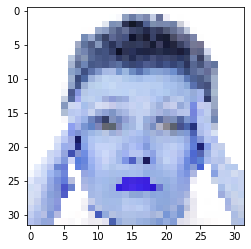

In [214]:
plt.imshow(cargar_imagenes()[1])

In [215]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = True
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [216]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
    
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [217]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [218]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [225]:
def save_plot(examples, epoch, n=1):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [226]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [233]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [234]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminador()
# create the generator
g_model = generador()
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = cargar_imagenes()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/2, d1=2.177, d2=0.695 g=0.692
>1, 2/2, d1=0.000, d2=0.697 g=0.691
>2, 1/2, d1=0.000, d2=0.699 g=0.689
>2, 2/2, d1=0.000, d2=0.703 g=0.686
>3, 1/2, d1=0.000, d2=0.713 g=0.677
>3, 2/2, d1=0.000, d2=0.738 g=0.657
>4, 1/2, d1=0.000, d2=0.792 g=0.613
>4, 2/2, d1=0.000, d2=0.909 g=0.530
>5, 1/2, d1=0.000, d2=1.191 g=0.389
>5, 2/2, d1=0.000, d2=1.804 g=0.216
>6, 1/2, d1=0.000, d2=2.811 g=0.093
>6, 2/2, d1=0.000, d2=3.938 g=0.042
>7, 1/2, d1=0.000, d2=4.505 g=0.028
>7, 2/2, d1=0.000, d2=4.655 g=0.028
>8, 1/2, d1=0.000, d2=4.481 g=0.033
>8, 2/2, d1=0.000, d2=4.237 g=0.038
>9, 1/2, d1=0.000, d2=4.136 g=0.041
>9, 2/2, d1=0.000, d2=4.019 g=0.040
>10, 1/2, d1=0.000, d2=4.098 g=0.038
>10, 2/2, d1=0.000, d2=4.230 g=0.038
>Accuracy real: 100%, fake: 0%
>11, 1/2, d1=3.363, d2=4.230 g=0.037
>11, 2/2, d1=0.000, d2=4.288 g=0.037
>12, 1/2, d1=0.000, d2=4.266 g=0.037
>12, 2/2, d1=0.000, d2=4.308 g=0.037
>13, 1/2, d1=0.000, d2=4.329 g=0.037
>13, 2/2, d1=0.000, d2=4.350 g=0.036
>14, 1/2, d1=0.000, d2=4.

KeyboardInterrupt: 

In [131]:
generate_real_samples(dataset, n_samples=20)[0].shape

(20, 32, 32, 3)

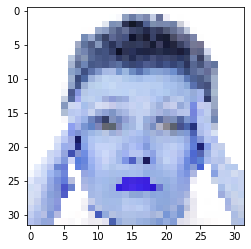

In [148]:
plt.imshow(generate_real_samples(dataset, n_samples=2)[0][0])

In [149]:
generate_fake_samples(g_model, latent_dim, 2)[0].shape

(2, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


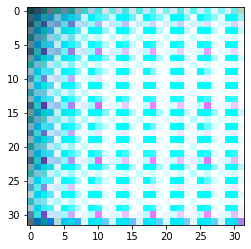

In [153]:
plt.imshow(generate_fake_samples(g_model, latent_dim, 2)[0][0])